# Library imports

In [ ]:
import argparse
import os
import random

import tarfile
import zipfile

import time
from __future__ import print_function
from __future__ import division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
import copy

import torchvision
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
import torchvision.utils as utils
from torchvision import datasets

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import ImageGrid
from tempfile import TemporaryDirectory
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

cudnn.benchmark = True

from IPython.display import HTML
from shutil import copyfile
from PIL import Image

# Set the CUBLAS_WORKSPACE_CONFIG environment variable
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

!pip install onedrivedownloader
from onedrivedownloader import download

## Dataset extracting

In [ ]:
def extract_dataset (file_path, extract_path, type = 'zip'):
  if type == 'tar':
    with tarfile.open(file_path, 'r') as td:
      td.extractall(extract_path)
  if type == 'zip':
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
      zip_ref.extractall(extract_path)


def dataset_download_extraction(dataset = 'EuroSAT'):

  dataset_path = ''
  if dataset == 'EuroSAT':
    link = 'https://unioulu-my.sharepoint.com/:u:/g/personal/mvanhala19_student_oulu_fi/EWSQ930mf1dJk7yDQ4hblVcB5YoikfOfQAyTmqYVljTxLg?e=WrgA1z'
    if not os.path.exists('./eurosat_rgb'):
      print('Downloading dataset')
      download(link, filename="./eurosat_rgb.zip")
      extract_dataset('./eurosat_rgb.zip', './eurosat_rgb', 'zip')
    dataset_path = './eurosat_rgb/EuroSAT_RGB'

  if dataset == 'miniImagenet':
    link = 'https://unioulu-my.sharepoint.com/:u:/g/personal/mvanhala19_student_oulu_fi/EVJGtgFfi6dJj0_UKc_tpNUBFnVBIJnRrvr27-Qfo3uOFQ?e=DlZFkL'
    if not os.path.exists('./miniImagenet.tar'):
      print('Downloading dataset')
      download(link, filename='./miniImagenet.tar')
      extract_dataset('./miniImagenet.tar', './miniImagenet', 'tar')
    dataset_path = './miniImagenet/train'

  if dataset == 'CUB':
    link = 'https://unioulu-my.sharepoint.com/:u:/g/personal/mvanhala19_student_oulu_fi/ESfjDqFc3TJDvgXKw6SJDGgBlCs-aiOwkGooN4VFyrfXPg?e=aP6tSr'
    if not os.path.exists('./CUBdataset.tgz'):
      print('Downloading dataset')
      download(link, filename='./CUBdataset.tgz')
      extract_dataset('./CUBdataset.tgz', './CUBdataset', 'tar')
    dataset_path = './CUBdataset/CUB_200_2011/images'

  if dataset == 'LeafDiseases':
    link = 'https://unioulu-my.sharepoint.com/:u:/g/personal/mvanhala19_student_oulu_fi/EVEehhz93QJGoFlZ2HqGA9YBmmPHF9Uhlk8uwWSr1YSZdw?e=Ab44hU'
    if not os.path.exists('./LeafDiseases'):
      print('Downloading dataset')
      download(link, filename='./LeafDiseases.tar')
      extract_dataset('./LeafDiseases.tar', './LeafDiseases', 'zip')
    dataset_path = './LeafDiseases/Plant_leave_diseases_dataset_with_augmentation'

  return dataset_path

# Training model with miniImagenet dataset

### Downloading the miniImageNet dataset

In [ ]:
# Downloading and extracting the miniImagenet dataset
miniimagenet_path = dataset_download_extraction('miniImagenet')

# Preprocess miniImagenet dataset
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],
                             std = [0.229, 0.224, 0.225])
])

miniimagenet_dataset = datasets.ImageFolder(miniimagenet_path, transform=transform)

100%|██████████| 126M/126M [00:07<00:00, 15.9MiB/s]


##Splitting the miniImagenet dataset

In [ ]:
# Split the dataset

train_size = int(0.8 * len(miniimagenet_dataset))
val_size = int(0.1 * len(miniimagenet_dataset))
test_size = len(miniimagenet_dataset) - train_size - val_size
train_set, val_set, test_set = random_split(miniimagenet_dataset, [train_size, val_size, test_size])

print('total number of total set: {}'.format(len(miniimagenet_dataset)))
print('total number of training set: {}'.format(len(train_set)))
print('total number of val set: {}'.format(len(val_set)))
print('total number of test set: {}'.format(len(test_set)))


total number of total set: 38400
total number of training set: 30720
total number of val set: 3840
total number of test set: 3840


## Creating dataloaders

In [ ]:
# Create dataloaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

## Training and evaluation functions

In [ ]:
# Evaluation function
def eval(model, data_loader):
    model.eval()
    correct = 0.0
    num_images = 0.0
    for i_batch, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        labels = labels.to(device)
        outs = model(images)
#         _, preds = outs.max(1)
        preds = outs.argmax(dim=1)
        correct += preds.eq(labels).sum()
        num_images += len(labels)

    acc = correct / num_images
    return acc

# Training function
def train(model, train_loader, valid_loader, epoches):

    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    for epoch in range(epoches):
        model.train()
        correct = 0.0 # used to accumulate number of correctly recognized images
        num_images = 0.0 # used to accumulate number of images
        for i_batch, (images, labels) in enumerate(train_loader):

            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outs = model(images)
            loss = loss_function(outs, labels)
            loss.backward()
            optimizer.step()
            preds = outs.argmax(dim=1)
            correct += preds.eq(labels).sum().item()
            num_images += len(labels)

        acc = correct / num_images
        acc_eval = eval(model, valid_loader)
        print('epoch: %d, lr: %f, accuracy: %f, loss: %f, valid accuracy: %f' % (epoch, optimizer.param_groups[0]['lr'], acc, loss.item(), acc_eval))

    return model



In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

## Model Initializing
Creates an option to choose between resnet18- and vgg11-model.

In [ ]:

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):

  model = None
  input_size = 0

  if model_name == "resnet":
    model = models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model, feature_extract)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    input_size = 224

  elif model_name == "vgg":
    model = models.vgg11_bn(pretrained=use_pretrained)
    set_parameter_requires_grad(model, feature_extract)
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, num_classes)
    input_size = 224

  elif model_name == "alexnet":
    model = models.alexnet(pretrained=use_pretrained)
    set_parameter_requires_grad(model, feature_extract)
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features,num_classes)
    input_size = 224

  elif model_name == "squeezenet":
    model = models.squeezenet1_0(pretrained=use_pretrained)
    set_parameter_requires_grad(model, feature_extract)
    model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
    model.num_classes = num_classes
    input_size = 224

  else:
    print("Invalid model name, exiting...")
    exit()

  return model, input_size



## Training the model

In [ ]:
# Choose to the preferred model
model_name = "squeezenet"                               #  <---

# Initialize the model for this run
feature_extract = False
num_classes = len(miniimagenet_dataset.classes)
model_pt, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained= True)

# Send the model to GPU
model_pt = model_pt.to(device)

epoches = 5                                          #  <---

# Setup the loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_pt.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 41.9MB/s]


In [ ]:
#print (model_pt)

In [ ]:
print('Please wait patiently, it may take some seconds...')
print('Using model: ', model_name)

# Train and evaluate
trained_net = train(model_pt, train_loader, valid_loader, epoches)

#test your network here on
acc_test = eval(trained_net, test_loader)

print('accuracy on testing data: %f' % acc_test)

Please wait patiently, it may take some seconds...
Using model:  squeezenet
epoch: 0, lr: 0.010000, accuracy: 0.366309, loss: 1.388867, valid accuracy: 0.603385
epoch: 1, lr: 0.010000, accuracy: 0.612793, loss: 1.376500, valid accuracy: 0.655208
epoch: 2, lr: 0.010000, accuracy: 0.671061, loss: 1.023380, valid accuracy: 0.689323
epoch: 3, lr: 0.010000, accuracy: 0.707715, loss: 0.843082, valid accuracy: 0.718229
epoch: 4, lr: 0.010000, accuracy: 0.725684, loss: 0.828048, valid accuracy: 0.698177
accuracy on testing data: 0.717708


## Saving the pretrained model

In [ ]:
# Save the trained model's state dictionary
torch.save(trained_net.state_dict(), 'trained_model_squeezenet.pth')

# Training model for fine-tuning

## Dataset preparation

In [ ]:
# Download and extract the dataset for finetuning
# Options: EuroSAT, CUB (CUB_200_2011), LeafDiseases
ft_dataset_path = dataset_download_extraction('CUB')

# Preprocess the dataset
ft_train_transform = transforms.Compose([
#    transforms.RandomResizedCrop((64, 64)),
#    transforms.RandomHorizontalFlip(),
#    transforms.RandomRotation(degrees=15),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                       std = [0.229, 0.224, 0.225]),
])

ft_test_transform = transforms.Compose([
#    transforms.RandomResizedCrop(eurosat_image_size),
#    transforms.RandomHorizontalFlip(),
#    transforms.RandomRotation(degree=15)
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                        std = [0.229, 0.224, 0.225]),
])

ft_dataset = datasets.ImageFolder(ft_dataset_path, transform= False)

100%|██████████| 1.15G/1.15G [00:21<00:00, 52.9MiB/s]


## Splitting the dataset to training and testing images

In [ ]:
def prepare_dataset(dataset, num_categories=5, images_per_category=20, train_split=5):
    """
    For part 1. a) iv.
    Prepare a subset of a dataset with a specified number of categories and images per category.

    Args:
    dataset: The dataset to process.
    num_categories: Number of unique categories to select.
    images_per_category: Number of images to select per category.
    train_split: Number of images to use for training in each category.

    Returns:
    training_images: Dictionary with training images.
    testing_images: Dictionary with testing images.
    selected_categories: List of selected categories.
    """
    # Get the list of all categories in the dataset
    all_categories = dataset.classes

    # Randomly select unique categories
    selected_categories = random.sample(all_categories, num_categories)

    # Select images from each of the selected categories
    training_images = {}
    testing_images = {}

    for category in selected_categories:
        # Get all images of the current category
        category_images = [image_path for image_path, label_index in dataset.imgs if dataset.classes[label_index] == category]

        # Randomly select images from the category
        selected_images = random.sample(category_images, images_per_category)

        # Assign images to the training and testing sets
        training_images[category] = selected_images[:train_split]
        testing_images[category] = selected_images[train_split:]

    return training_images, testing_images, selected_categories


## Creating custom dataset for the images

In [ ]:
class new_dataset(Dataset):
    """New custom dataset for selected categories and images"""

    def __init__(self, image_paths, selected_categories, transform=None):
        """
        image_paths: Dictionary of categories and their corresponding image paths
        transform: Transformations to be applied to images
        """
        self.image_paths = []
        self.labels = []
        self.transform = transform

        # Map category names to indices
        category_to_index = {category: idx for idx, category in enumerate(selected_categories)}

        # Flatten the dictionary into lists
        for label, paths in image_paths.items():
            index = category_to_index[label]
            self.image_paths.extend(paths)
            self.labels.extend([index] * len(paths))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        image_path = self.image_paths[idx]
        image = Image.open(image_path)

        # Apply transformation
        if self.transform:
            image = self.transform(image)

        # Get label
        label = self.labels[idx]

        return image, label


In [ ]:
def sample_selection(dataset, ft_test_transform, ft_train_transform):
  # Preparing the dataset
  training_images, testing_images, selected_categories = prepare_dataset(dataset)

  # Creating datasets with a custom model (ft = fine tuning)
  ft_train_dataset =  new_dataset(training_images, selected_categories, transform=ft_train_transform)
  ft_test_dataset =  new_dataset(testing_images, selected_categories, transform=ft_test_transform)

  batch_size = 8
  # Create training and validation datasets
  image_datasets = {

                  'train': ft_train_dataset,
                  'val': ft_test_dataset,
                  }
  dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
  # Create training and validation dataloaders
  dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

  return training_images, testing_images, selected_categories, ft_train_dataset, ft_test_dataset, dataloaders_dict


In [ ]:
training_images, testing_images, selected_categories, ft_train_dataset, ft_test_dataset, dataloaders_dict = sample_selection(ft_dataset, ft_test_transform, ft_train_transform)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


##Visualization of fine tuning dataset
Helps to see if the dataset was properly downloaded and divided, and the images labeled correctly

In [ ]:
def visualize_dataset(dataset, selected_categories, num_to_show=5):
    """
    Visualizes a random selection of images from the dataset and prints the count of images per class.

    Args:
    dataset: The dataset.
    selected_categories: The list of selected categories.
    num_to_show: Number of images to display.
    """
    # Randomly pick images to show
    idx = np.random.choice(range(len(dataset)), num_to_show, replace=False)

    fig = plt.figure(figsize=(16, 8))
    for i in range(len(idx)):
        image, label_index = ft_train_dataset[idx[i]]
        label_name = selected_categories[label_index]

        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

        ax = plt.subplot(1, num_to_show, i + 1)
        plt.tight_layout()
        ax.set_title('{}'.format(label_name))
        ax.axis('off')
        plt.imshow(image)
    plt.show()

    # Print number of images for each class in the training set
    print('Total number of training set:', len(dataset))
    class_counts = {category: 0 for category in selected_categories}
    for index in dataset.labels:
        category_name = selected_categories[index]  # Convert index to category name
        class_counts[category_name] += 1  # Update count using category name

    for category, count in class_counts.items():
        print('Number of images for class {}: {}'.format(category, count))



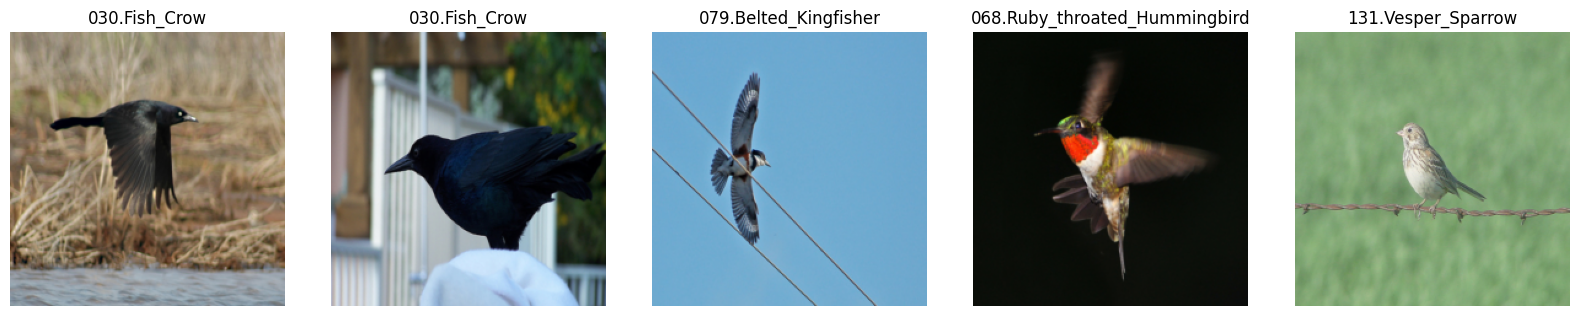

In [ ]:
visualize_dataset(ft_train_dataset, selected_categories, num_to_show=5)

## Training function

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    print(model_name)
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):


        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
              scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            # If epochs are set high, printing is done only once per 10 epochs
            if num_epochs >= 50:
                if epoch % 10 == 0:
                    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
                    print('-' * 10)
                    print('{} learning rate {:.4f} Loss: {:.4f} Acc: {:.4f}'.format(phase, optimizer.param_groups[0]['lr'], epoch_loss, epoch_acc))
                    print()
            else:
                print('Epoch {}/{}'.format(epoch, num_epochs - 1))
                print('-' * 10)
                print('{} learning rate {:.4f} Loss: {:.4f} Acc: {:.4f}'.format(phase, optimizer.param_groups[0]['lr'], epoch_loss, epoch_acc))
                print()

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)



    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

Total number of training set: 25
Number of images for class 079.Belted_Kingfisher: 5
Number of images for class 131.Vesper_Sparrow: 5
Number of images for class 068.Ruby_throated_Hummingbird: 5
Number of images for class 121.Grasshopper_Sparrow: 5
Number of images for class 030.Fish_Crow: 5


## Finetuning

In [ ]:
model_name = "vgg" # resnet/vgg/alexnet/squeezenet
feature_extract = True # True to freeze all layers except last FC layer

In [ ]:
#num_classes = len(miniimagenet_dataset.classes)

num_classes = 10

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained= './trained_model_vgg_aug.pth')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:03<00:00, 148MB/s]


In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

num_epochs = 100

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

episodes = 5
hist_ep = {}

#hist_ep[i] = []
for i in range (episodes):
# Observe that all parameters are being optimized
  optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.8 every 10 epochs
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.8)

  print("Episode #: ", i)
  training_images, testing_images, selected_categories, ft_train_dataset, ft_test_dataset, dataloaders_dict = sample_selection(ft_dataset, ft_test_transform, ft_train_transform)

# Train and evaluate
  model_ft, hist_ep[i] = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)

# Calculate and print the average of the accuracies
#average_acc = sum(hist_ep) / episodes
#print(f'Average accuracy over {episodes} runs: {average_acc}')
average_acc = sum([max(hist) for hist in hist_ep.values()]) / episodes
print(f'Average accuracy over {episodes} runs: {average_acc}')

Episode #:  0
vgg
Epoch 0/99
----------
train learning rate 0.0100 Loss: 2.2341 Acc: 0.1600

Epoch 0/99
----------
val learning rate 0.0100 Loss: 0.9520 Acc: 0.6267

Epoch 10/99
----------
train learning rate 0.0080 Loss: 0.9119 Acc: 0.9200

Epoch 10/99
----------
val learning rate 0.0080 Loss: 1.7530 Acc: 0.7600

Epoch 20/99
----------
train learning rate 0.0064 Loss: 0.6586 Acc: 0.8000

Epoch 20/99
----------
val learning rate 0.0064 Loss: 1.7139 Acc: 0.7067

Epoch 30/99
----------
train learning rate 0.0051 Loss: 0.1768 Acc: 0.9200

Epoch 30/99
----------
val learning rate 0.0051 Loss: 3.7522 Acc: 0.6933

Epoch 40/99
----------
train learning rate 0.0041 Loss: 0.3066 Acc: 0.9600

Epoch 40/99
----------
val learning rate 0.0041 Loss: 1.5203 Acc: 0.8133

Epoch 50/99
----------
train learning rate 0.0033 Loss: 0.0018 Acc: 1.0000

Epoch 50/99
----------
val learning rate 0.0033 Loss: 0.8543 Acc: 0.8267

Epoch 60/99
----------
train learning rate 0.0026 Loss: 0.0155 Acc: 1.0000

Epoch 60

## Saving fine tuned model

In [ ]:
torch.save(model_ft.state_dict(), 'fine_tuned_model_vgg_CUB.pth')

# Visualization

## Visualizing the training process

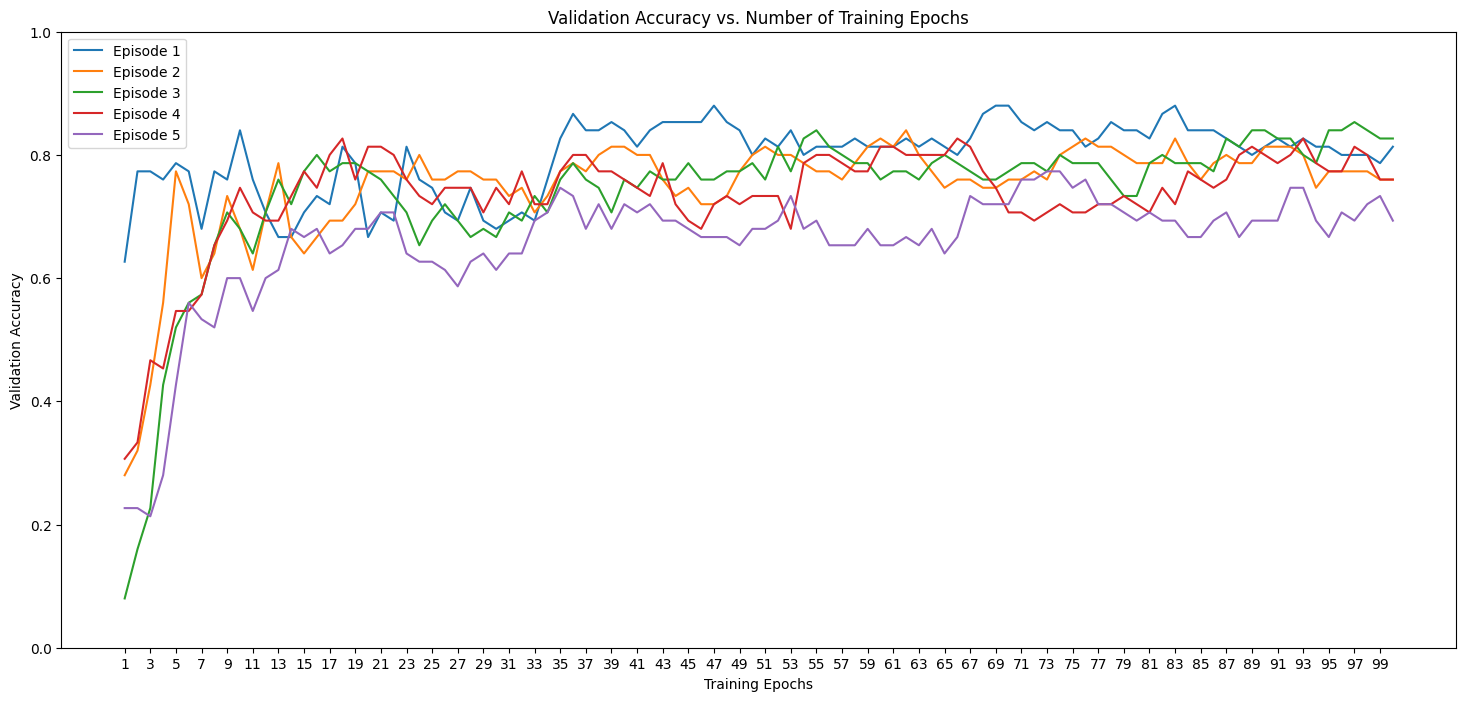

In [ ]:
ohist = {}
shist = []

plt.figure(figsize=(18, 8))

for i in range (episodes):
  ohist[i] = [h.cpu().numpy() for h in hist_ep[i]]
  plt.plot(range(1,num_epochs+1),ohist[i],label=f"Episode {i + 1}")

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 2.0))
plt.legend()
plt.show()

## Visualizing the finetuning results

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    # Calculate the number of columns required to display 'num_images' images
    num_columns = num_images
    num_rows = 1

    # Set up the matplotlib figure and axes
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(num_columns * 3, num_rows * 3))

    # If num_images is 1, axs won't be an array, so we wrap it in one for uniform handling
    if num_images == 1:
        axs = [axs]

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders_dict['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if images_so_far >= num_images:
                    break  # Break if we have already shown 'num_images' images

                actual_label = selected_categories[labels[j]]
                predicted_label = selected_categories[preds[j]]

                axs[images_so_far].axis('off')  # Turn off axis
                axs[images_so_far].set_title(f'actual: {actual_label}\npredicted: {predicted_label}')

                # Call imshow on the correct subplot
                imshow(inputs.cpu().data[j], ax=axs[images_so_far])

                images_so_far += 1

            if images_so_far >= num_images:
                break  # Break the outer loop if we have already shown 'num_images' images

    # If we haven't used all the subplot areas, turn off any unused ones.
    for k in range(images_so_far, num_columns):
        axs[k].axis('off')

    plt.tight_layout()
    model.train(mode=was_training)
    plt.show()  # Display the figure



In [ ]:
def imshow(inp, ax=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)


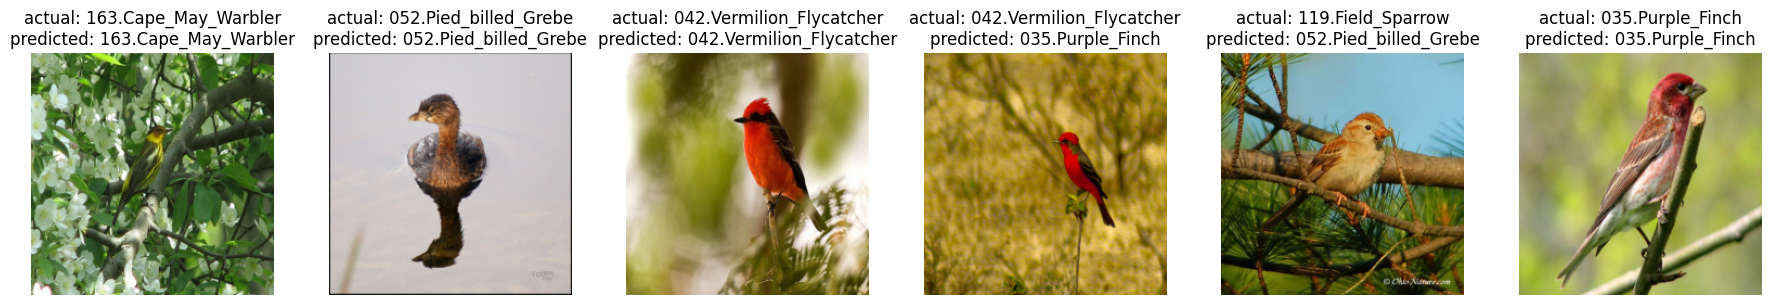

In [ ]:
visualize_model(model_ft)